# Project 2: Segmentation

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Setting up PyMaxFlow: <span style="color:red;">FILL IN TIME</span>
* 2. Getting your first successful segmentation: <span style="color:red;">FILL IN TIME</span>
* 3. Adjusting parameters (e.g. $\lambda$, $\sigma$) and so forth, to get good results: <span style="color:red;">FILL IN TIME</span>
* 4. Completing the write-up: <span style="color:red;">FILL IN TIME</span>

Note that there are two folders within the project.  We have provided some images for you to use in testing your implementation, in the `provided images` folder along with their ground-truth segmentations to compare your results to.  Along with these, we want you to provide 2-4 additional images that you select on which you show your results.  <i>Please use the `provided_images` in that path and place any others in the `user_data` folder, and load all of the images (or user input point location files) via the approapriate relative path.  We will drop your notebook file and your `user_data` folder into our folder (which will have the `provided_images` already) and then run your notebook.</i>




## Preparation:
So that you can focus on the elements of the cost function ( the link weights), you may use a existing implementation of the actual min-cut algorithm itself.  You set up the graph, but it will take care of finding the minimum cut.

For this assignment we will be using a python library called PyMaxFlow.  This library is a python wrapper around the original C++ implementation of the min-cut code from [Vladimir Kolmogorov](http://pub.ist.ac.at/%7Evnk/software.html) (who has co-authored several papers on this subject).    

Note: For windows users, you will need the Visual C++ compiler in order for PyMaxFlow to work.  If you already have Visual Studio, this shouldn't be a problem but if you just want the compiler without Visual Studio, you can download [Build Tools For Visual Studio 2017](https://visualstudio.microsoft.com/downloads/#build-tools-for-visual-studio-2017). Once you have access to the Visual C++ compiler look at the next paragraph for PyMaxFlow installation.

PyMaxFlow requires Cython, which should come standard in your anaconda environment but the command to install that will also be included.  To install PyMaxFlow enter the following commands replacing "YourEnvironmentName" with the name of your anaconda environment.
~~~
conda activate YourEnvironemntName
conda install cython
pip install pymaxflow
~~~
Once PyMaxFlow is installed, to understand how to use the library, there is a great [tutorial page](http://pmneila.github.io/PyMaxflow/tutorial.html) that shows how to get started with some simple examples.  Do the "first example" and perhaps the "binary image restoration" as well.

In [1]:
import maxflow

In [253]:
import tkinter as tk
from PIL import ImageTk, Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import draw
import networkx as nx
from scipy import stats

def get_fore_back(im):
    """
    Function: get_fore_back
    -----------------------
    Opens a GUI that can be used to annotate the given image with foreground and background seeds
    
    Args:
    -----
        im: The input image can either be of type uint8 with range [0,255] or float with range[0, 1]
    
    Returns:
    --------
        a tuple containing locations for the foreground seeds and a tuple containing locations for the background seeds
        
    Example:
    --------
    >> fore, back = get_fore_back(img)
    >> img[fore]  # the foreground pixels
    >> img[back]  # the background pixels
    """

    if im.dtype != np.uint8 and np.max(im) <= 1.0 and np.min(im) >= 0:
        img = np.uint8(255 * im)
    elif im.dtype == np.uint8 and np.max(im) <= 255 and np.min(im) >= 0:
        img = im.copy()
    else:
        raise ValueError("Input image must be either dtype uint8 with range [0, 255] or float with range [0, 1] but got im.dtype = {}".format(im.dtype))
        
        
    ground_num = 1
    anno = np.zeros(img.shape[:-1])
    lastx = 0
    lasty = 0
    colors = {
        1:"red",
        2:"blue"
    }
    
    def reset():
        nonlocal anno, photo
        anno = np.zeros(img.shape[:2])
        canvas.create_image(img.shape[1]//2, img.shape[0]//2, image=photo)
        
    def set_ground_num(num):
        nonlocal ground_num
        ground_num = num
        
    def mouse_down(event):
        nonlocal anno, lastx, lasty, canvas, colors, ground_num
        h, w = anno.shape
        lastx = min(max(event.x, 0), w - 1)
        lasty = min(max(event.y, 0), h - 1)
        x = min(max(event.x - 1, 0), w - 1)
        y = min(max(event.y - 1, 0), h - 1)
        canvas.create_line(lastx, lasty, x, y, fill=colors[ground_num])
        rr, cc = draw.line(lastx, lasty, x , y)
        anno[cc, rr] = ground_num

    def mouse_drag(event):
        nonlocal anno, lastx, lasty, canvas, colors, ground_num
        h, w = anno.shape
        x = min(max(event.x, 0), w - 1)
        y = min(max(event.y, 0), h - 1)
        canvas.create_line(lastx, lasty, x, y, fill=colors[ground_num])
        rr, cc = draw.line(lastx, lasty, x , y)
        anno[cc, rr] = ground_num
        lastx = x
        lasty = y
        
    root = tk.Tk()
    
    btn_frame = tk.Frame(root)
    btn_frame.pack(side=tk.TOP)
    
    reset_btn = tk.Button(btn_frame, text='Reset',command=reset)
    reset_btn.pack(side=tk.LEFT)
    
    fore_btn = tk.Button(btn_frame, text='Foreground', command=lambda: set_ground_num(1))
    fore_btn.pack(side=tk.LEFT)
    
    back_btn = tk.Button(btn_frame, text='Background', command=lambda: set_ground_num(2))
    back_btn.pack(side=tk.LEFT)
    
    return_btn = tk.Button(btn_frame, text='Return', command=root.destroy)
    return_btn.pack(side=tk.LEFT)
    
    canvas = tk.Canvas(root, width=img.shape[1], height=img.shape[0])
    canvas.bind("<Button-1>", mouse_down)
    canvas.bind("<B1-Motion>", mouse_drag)
    photo = ImageTk.PhotoImage(Image.fromarray(img))
    canvas.pack(side=tk.BOTTOM)
    reset()
    root.mainloop()
    f = np.where(anno == 1)
    b = np.where(anno == 2)
    # return np.vstack((f[0], f[1])).T, np.vstack((b[0], b[1])).T
    return f, b
    # return np.vstack((f[0], f[1])), np.vstack((b[0], b[1]))
res = get_fore_back(plt.imread('provided_images/simplecircle.png'))




## Annotations:
Graph cut segmentation is an interactive algorithm requiring the user to provide foreground and background seeds.  Provided is a python file that will open a gui and allow you to annotate the image.  This gui is optional and will require additional packages to be installed into your environment.  To install the packages open a terminal and enter the following commands:
~~~
conda activate YourEnvironmentName
conda install scikit-image pillow
~~~
You can use the gui in the following way:
```python
import guiseg
fore, back = guiseg.get_fore_back(image)
image[fore]  # the foreground seeds
image[back]  # the background seeds
```

For the `guiseg` routine to run, I also found it necssary to install PIL ImageTk (For me, it was `sudo apt install python3-pil.imagetk` but it will be different for Conda).

In [3]:
import cv2
#imageBGR = cv2.imread('provided_images/simplecircle.png');
imageBGR = cv2.imread('provided_images/banana.png');
image = imageBGR[:,:,::-1]; # I reverse the BGR from OpenCV to BGR

# When the GUI pops up, you can pick either the "Foreground" or "Background" buttons to
# select pixels to be respective seeds.  Once you're finished, click "Return"
fore, back = get_fore_back(image)
print(image[fore][:5])  # foreground seeds (RGB values for all pixels drawn on, but only showing 5)
print(image[back][:5])  # background seeds (RGB values for all pixels drawn on, but only showing 5)

[[45 33 21]
 [43 34 19]
 [53 37 24]
 [48 36 22]
 [47 35 19]]
[[202 133  29]
 [203 134  30]
 [204 136  35]
 [202 138  30]
 [203 136  31]]




## Graph Cut:
Your code should read in an image and a set of seed pixels and use graph-cut segmentation to segment the image.

You will need to calculate the costs for the t-links (region terms) and the n-links (boundary terms). See the book, the notes/slides, or published papers in this area for ideas of how to define these.  Remember that the t-link weights to a particular terminal (foreground or background) should be large if that pixel looks a lot like the respective foreground/background seeds. The n-link weights should be large if the two neighboring pixels are similar.

Here is [the original paper on graph-cut segmentation](http://www.csd.uwo.ca/~yuri/Papers/iccv01.pdf), which might help with some ideas, but you should look at the literature to see what other costs functions / link weights others have used.

Once the graph is built, use the min-cut algorithm to partition the graph into nodes connected to the foreground node or to the background node, then use these as the resulting labels for the segmentation. Display this result graphically in some fashion overlaid on the input image.  It is best to start with simple images whose foreground and background colors are pretty different and for ones where the edges are pretty clear.  Graph-cut segmentation struggles sometimes with long, thin structures, so you should avoid these types of images early on.



0.0


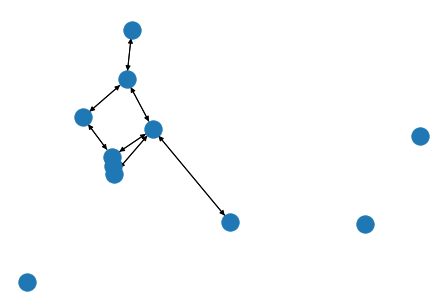

In [96]:
g = maxflow.GraphFloat()
nodeids = g.add_grid_nodes((3, 3))
structure = np.array([[0, 1, 0],
                      [1, 0, 1],
                      [0, 1, 0]])
weights = np.array([[0, .2, 10],
                    [.1, .02, 0],
                    [0, 0, 0]])
g.add_grid_edges(nodeids, weights=weights, structure=structure, symmetric=True)
flow = g.maxflow()
print(flow)
graph = g.get_nx_graph()
nx.draw(graph)

In [280]:
# Implementation Here (feel free to add additional cells of course)

def get_left_right_weights(img, sigma=1):  
    img_left_slice = img[:, 1:, :]
    img_right_slice = img[:, :-1, :]
    right_left_diff = np.linalg.norm(img_left_slice - img_right_slice, axis=2)
    left_right_weights = stats.norm.pdf(right_left_diff, loc=0, scale=sigma)
    return left_right_weights

def get_up_down_weights(img, sigma=1):  
    img_up_slice = img[1:, :, :]
    img_down_slice = img[:-1, :, :]
    up_down_diff = np.linalg.norm(img_up_slice - img_down_slice, axis=2)
    up_down_weights = stats.norm.pdf(up_down_diff, loc=0, scale=sigma)
    return up_down_weights

def build_kdes(fg_seeds, bg_seeds):
    fg_seeds = np.transpose(fg_seeds)
    bg_seeds = np.transpose(bg_seeds)
    fg_kernel = stats.gaussian_kde(fg_seeds)
    bg_kernel = stats.gaussian_kde(bg_seeds)
    return fg_kernel, bg_kernel

def get_pixel_likelihoods(p, fg_kernel, bg_kernel):
    return fg_kernel(p), bg_kernel(p)

def region_penalty(img):
    rows, cols, channels = img.shape
    fg_seeds, bg_seeds = get_fore_back(img)
    
    fg_kernel, bg_kernel = build_kdes(img[fg_seeds], img[bg_seeds])
    likelihoods = np.array([[[fg_kernel(img[i, j]), bg_kernel(img[i, j])]
                             for j in range(cols)] for i in range(rows)])
    fg_likelihoods = -np.log(np.squeeze(likelihoods[:, :, 0], axis=2))
    bg_likelihoods = -np.log(np.squeeze(likelihoods[:, :, 1], axis=2))
    
    return fg_likelihoods, bg_likelihoods, fg_seeds, bg_seeds

In [278]:
# Create the graph.
def get_boundary_segs(img, sig=0.5, lambda_const=100):
    rows, cols, channels = img.shape
    g = maxflow.Graph[float]()
    # Add the nodes. nodeids has the identifiers of the nodes in the grid.
    # Note that nodeids.shape == img.shape
    nodeids = g.add_grid_nodes((rows, cols))

    # left right neighbor weights
    left_right_weights = get_left_right_weights(img, sigma=sig)
    g.add_grid_edges(nodeids[:, :-1], left_right_weights, symmetric=True)
    # up down neighbor weights
    up_down_weights = get_up_down_weights(img, sigma=sig)
    g.add_grid_edges(nodeids[:-1, :], up_down_weights, symmetric=True)
    
    # Add t-edges for using the regional likelihoods
    fg_likelihoods, bg_likelihoods, fg_seeds, bg_seeds = region_penalty(img)
    g.add_grid_tedges(nodeids, (1/lambda_const)*fg_likelihoods,
                               (1/lambda_const)*bg_likelihoods)

    # Find the maximum flow.
    mflow = g.maxflow()
    # Get the segments of the nodes in the grid.
    # sgm.shape == nodeids.shape
    sgm = g.get_grid_segments(nodeids)
    # The labels should be 1 where sgm is False and 0 otherwise.
    img2 = np.int_(sgm)
    # Show the result.
    plt.imshow(img2, cmap='gray')
    plt.show()
    return sgm, fg_seeds, bg_seeds

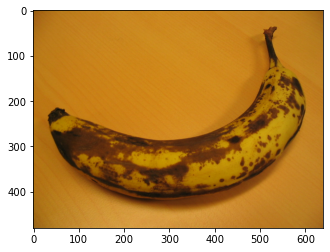

In [281]:
# Generate results Here (again, add additional cells to your heart's content)
img = plt.imread("provided_images/banana.png")
plt.imshow(img)

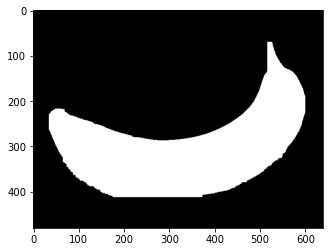

In [282]:
sgm, fg_seeds, bg_seeds = get_boundary_segs(img)

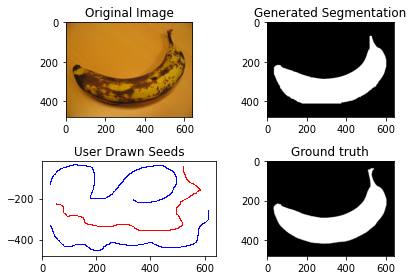

In [303]:
fig, axs = plt.subplots(2, 2)
rows, cols, channels = img.shape

axs[0, 0].set_title("Original Image")
axs[0, 0].imshow(img)

axs[1, 0].set_title("User Drawn Seeds")
axs[1, 0].plot(fg_seeds[1], -fg_seeds[0], figsize=(rows, cols), 'r,')
axs[1, 0].plot(bg_seeds[1], -bg_seeds[0], 'b,')

axs[0, 1].set_title("Generated Segmentation")
axs[0, 1].imshow(sgm, cmap='gray')

axs[1, 1].set_title("Ground truth")
g_truth = plt.imread('provided_images/ground_truth/banana-seg.png')
axs[1, 1].imshow(g_truth, cmap='gray')
3
plt.tight_layout()

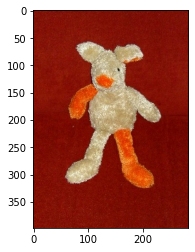

In [304]:
img = plt.imread("provided_images/teddy.png")
plt.imshow(img)

C:\Users\scarp\AppData\Local\Temp/ipykernel_11388/2511230125.py:35: RuntimeWarning: divide by zero encountered in log
  bg_likelihoods = -np.log(np.squeeze(likelihoods[:, :, 1], axis=2))


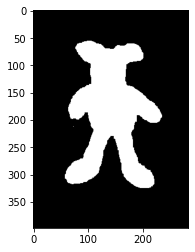

In [305]:
sgm, fg_seeds, bg_seeds = get_boundary_segs(img)

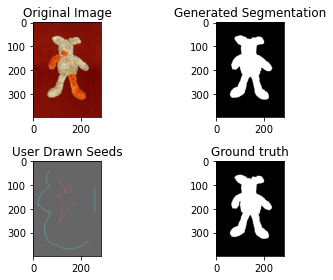

In [335]:
fig, axs = plt.subplots(2, 2)
rows, cols, channels = img.shape

axs[0, 0].set_title("Original Image")
axs[0, 0].imshow(img)

axs[1, 0].set_title("User Drawn Seeds")
canvas = np.ones((rows, cols, 3))*0.4
canvas[fg_seeds[0], fg_seeds[1], 0] = 1
canvas[bg_seeds[0], bg_seeds[1], 2] = 1
canvas[bg_seeds[0], bg_seeds[1], 1] = 1
axs[1, 0].imshow(canvas)


axs[0, 1].set_title("Generated Segmentation")
axs[0, 1].imshow(sgm, cmap='gray')

axs[1, 1].set_title("Ground truth")
g_truth = plt.imread('provided_images/ground_truth/teddy-seg.png')
axs[1, 1].imshow(g_truth, cmap='gray')

plt.tight_layout()

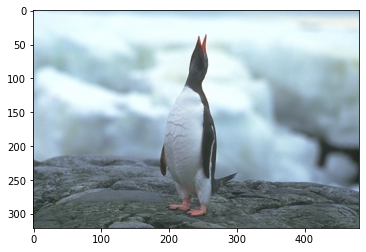

In [336]:
img = plt.imread("provided_images/penguin.png")
plt.imshow(img)

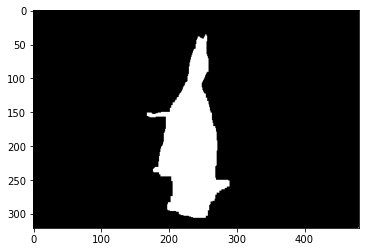

In [341]:
sgm, fg_seeds, bg_seeds = get_boundary_segs(img, sig=20)

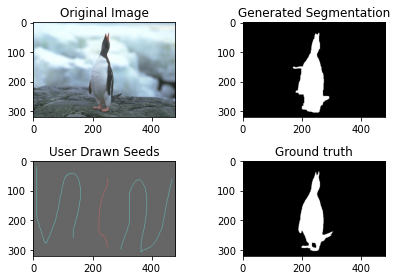

In [342]:
fig, axs = plt.subplots(2, 2)
rows, cols, channels = img.shape

axs[0, 0].set_title("Original Image")
axs[0, 0].imshow(img)

axs[1, 0].set_title("User Drawn Seeds")
#axs[1, 0].figure(figsize=(rows, cols))
canvas = np.ones((rows, cols, 3))*0.4
canvas[fg_seeds[0], fg_seeds[1], 0] = 1
canvas[bg_seeds[0], bg_seeds[1], 2] = 1
canvas[bg_seeds[0], bg_seeds[1], 1] = 1
#canvas = np.logical_or(fg, bg)
axs[1, 0].imshow(canvas)
#axs[1, 0].plot(fg_seeds[1], -fg_seeds[0], 'r,')
#axs[1, 0].plot(bg_seeds[1], -bg_seeds[0], 'b,')

axs[0, 1].set_title("Generated Segmentation")
axs[0, 1].imshow(sgm, cmap='gray')

axs[1, 1].set_title("Ground truth")
g_truth = plt.imread('provided_images/ground_truth/penguin-seg.png')
axs[1, 1].imshow(g_truth, cmap='gray')

plt.tight_layout()

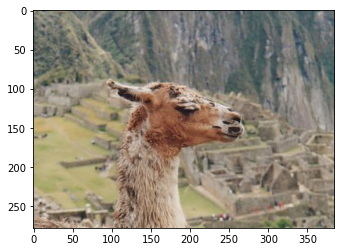

In [344]:
img = plt.imread("provided_images/llama.jpg")
plt.imshow(img)

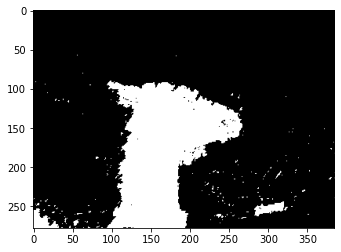

In [354]:
sgm, fg_seeds, bg_seeds = get_boundary_segs(img, sig=15, lambda_const = 10000)

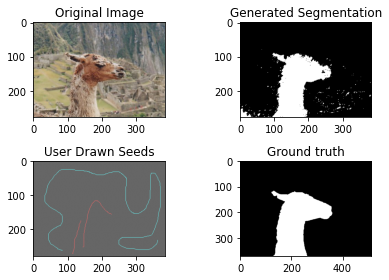

In [352]:
fig, axs = plt.subplots(2, 2)
rows, cols, channels = img.shape

axs[0, 0].set_title("Original Image")
axs[0, 0].imshow(img)

axs[1, 0].set_title("User Drawn Seeds")
#axs[1, 0].figure(figsize=(rows, cols))
canvas = np.ones((rows, cols, 3))*0.4
canvas[fg_seeds[0], fg_seeds[1], 0] = 1
canvas[bg_seeds[0], bg_seeds[1], 2] = 1
canvas[bg_seeds[0], bg_seeds[1], 1] = 1
#canvas = np.logical_or(fg, bg)
axs[1, 0].imshow(canvas)
#axs[1, 0].plot(fg_seeds[1], -fg_seeds[0], 'r,')
#axs[1, 0].plot(bg_seeds[1], -bg_seeds[0], 'b,')

axs[0, 1].set_title("Generated Segmentation")
axs[0, 1].imshow(sgm, cmap='gray')

axs[1, 1].set_title("Ground truth")
g_truth = plt.imread('provided_images/ground_truth/llama-seg.png')
axs[1, 1].imshow(g_truth, cmap='gray')

plt.tight_layout()

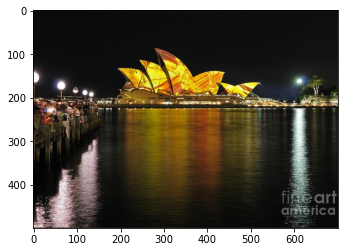

In [357]:
img = plt.imread("provided_images/opera.jpg")
plt.imshow(img)

C:\Users\scarp\AppData\Local\Temp/ipykernel_11388/2511230125.py:35: RuntimeWarning: divide by zero encountered in log
  bg_likelihoods = -np.log(np.squeeze(likelihoods[:, :, 1], axis=2))


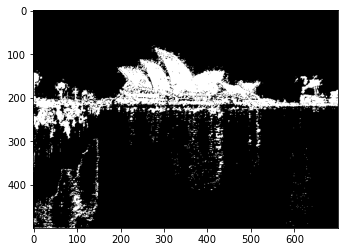

In [361]:
sgm, fg_seeds, bg_seeds = get_boundary_segs(img, sig=3, lambda_const = 10000000)

In [369]:
"""This one is not too bad because it has some high contrast between the object and the 
background since the object is well lit."""

'This one is not too bad because it has some high contrast between the object and the \nbackground since the object is well lit.'

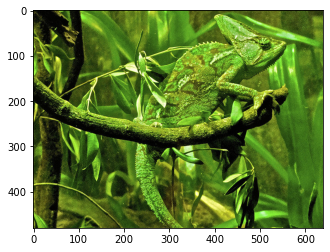

In [363]:
img = plt.imread("provided_images/chameleon.jpg")
plt.imshow(img)

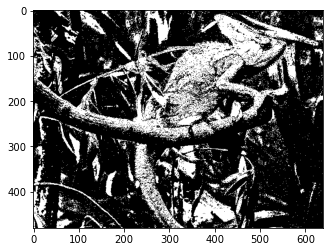

In [364]:
sgm, fg_seeds, bg_seeds = get_boundary_segs(img, sig=2, lambda_const = 10e10)

In [368]:
"""This one is insane because the whole pictur is the same color and there are lots of 
interleaving edges. Even when the lambda value is massive, it still pretty much changes
the image to black and white."""

'This one is insane because the whole pictur is the same color and there are lots of \ninterleaving edges. Even when the lambda value is massive, it still pretty much changes\nthe image to black and white.'


## Grading / Rubric
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Code that correctly generates the graph network structure (nodes, n-links, t-links).
* [10 pts] Code that produces the boundary term $B(p,q)$ used for n-links.
* [10 pts] Code that produces the region term of the cost $R(p,A)$ used for the t-links.  Remember that you have t-links per pixel, one with cost determined by matching $p$ with the foreground appearance distribution, the other determined relative to the background distribution.  You may use the [sk-learn implementation](https://scikit-learn.org/stable/modules/density.html#kernel-density-estimation) of Kernel Density Estimation.  However you will receive 10 extra points if you implement it yourself.
* [20 pts] Implementing the graph-cut with `pymaxflow` and finding the optimal solution for the input graph.
* [10 pts] Displaying Results in the following format (for each input image you'll show the following 3-4 result images):
   1. Original Image.
   2. Tri-map of what was selected by the user (white for foreground, black for background, gray for unknown).  This can be overlaid on top of a faint copy of the image for context if desired.
   3. Final segmentation.  Again you can overlay it on a faint copy of the original for context.
   4. On the <i>provided images</i> please show a comparison of your resulting segmentation with the ground truth.
* [20 pts] Good (certainly not perfect, some of them are challenging, but decent/reasonable) results on the 4 provided images (banana, llama, penguin, teddy).  Each image will receive up to 5 points.
* [10 pts] Demonstrating your algorithm on 2-4 additional images.  At least one of the images should be somewhat easy, one should be somewhat challenging -- expalin why you think they're respectively easy/challenging.


## Write-up:
Provide an explanation for the following items:
* Describe how you determinied/computed the n-link and t-link weights.
* What kinds of image does graph cut segmentation work well for? What kinds of images do you find it struggles with?
* What did you learn from the project?
* What if any suggestions do you have for improving it (for future students)?

<span style="color:red;">WRITE-UP HERE</span>
For the n links, I duplicated the image and sliced off one column from one side of one the copies and sliced off one column from the other side in the other copy. I took the difference between both of the images in terms of their norm (since this was an RGB image). Then I plugged their normed differences into a normal distribution and those became the weights for my n-links for left-right neighbors. I did the same thing for up and down neighbors except I sliced the top and bottom columns instead. The t-link neighbors were calculated by building a KDE built from the user inputted seeds of the image. One KDE for the object, and one for the background. Plugging in each pixel of the image into each KDE gave me likelihoods of belonging to the background or object classes. Then I plugged in those likelihoods into the weights for add t edges function in pymaxflow.

This algorithm works well when you don't have very much noise and there is good contrast between the image and the background. Also the algorithm can have a hard time classifying an object if the object consists of contrasting colors like black and white.

I learned about KDE's. I have learned about them before but I never used them in a real world application like this. I also learned that pymaxflow is pretty dope.

I think making a 1 paragraph step by step implementation (not too detailed) of this would have helped. For example, I had a hard time understanding how to combine the regional and boundary penalties into one optimization problem in pymaxflow. It's not hard to do but it was tricky to understand how exactly I was supposed to do it using pymaxflow.